# **Datalet SHE HULK LOAN para el grupo de Actuarios de ACME Inc.**

## **Problema:**

Trabajaremos en conjunto al analista de negocio de la financiera de **_ACME_**. **_ACME_** Busca implementar un software que les permita conocer si un cliente pagará su préstamo o no.

Para ello, se empleará el histórico que se tiene de 2007 a 2011, el cual incluye el status de préstamo actual y la última información de pago.

Para esto se empleará una arquitectura de Python 3.10 con las siguientes librerias:
1. Pandas==1.4.4
2. Numpy==1.18.5
3. Imlearn
4. Sklearn
5. matplotlib
6. Collections

### **Pasos a seguir:**

Importamos las librerias que usaremos:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from collections import Counter
from imblearn.over_sampling import SMOTENC

Cargamos nuestros datasets.
En este caso, se encuentran separados, por lo que tendremos que aplicar un join para poder unirlos.
\
Procederemos a ver qué trae nuestros datasets con un .head().
\
Dado que buscamos la información de los dos, usaremos un "inner".

In [2]:
loan1 = pd.read_csv('loans-part-1.csv')
loan2 = pd.read_csv('loans-part-2.csv')

In [3]:
loan1.head(2)

,id,loan_status,loan_amount,funded_amount_by_investors,loan_term,interest_rate,installment,grade,sub_grade,verification_status,issued_on,purpose,dti,earliest_credit_line,inquiries_last_6_months,open_credit_lines,derogatory_public_records,revolving_line_utilization_rate,total_credit_lines
0,1077501,fully paid,5000,4975.0,36,10.65,162.87,b,b2,verified,2011-12-01,credit_card,27.65,1985-01-01,1,3,0,83.7,9
1,1077430,charged off,2500,2500.0,60,15.27,59.83,c,c4,source verified,2011-12-01,car,1.00,1999-04-01,5,3,0,9.4,4


In [4]:
loan2.head(2)

,id,employment_length,employer_title,home_ownership,annual_income
0,1077501,10.0,NaN,rent,24000.0
1,1077430,1.0,ryder,rent,30000.0


In [5]:
loans = pd.merge(loan1, loan2, how='inner', on=['id'])

Toca evaluar qué tan distribuido esta nuestro **target**($ \hat{y} $) para ver el balance de nuestro dataset.

In [6]:
for i in range(0,3):
    print(f'{loans.loan_status.value_counts().index[i]} {round(loans.loan_status.value_counts().values[i]/loans.loan_status.value_counts().values.sum()*100,0)}%')

fully paid 83.0%
charged off 14.0%
current 3.0%


Observamos que nuestro dataset esta desbalanceado claramente, pues más del 80% de nuestro target se encuentra en una sola opción, por lo que nuestro modelo se sesgaría al dejar la data de dicha manera.

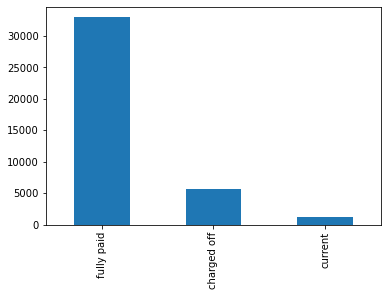

In [7]:
loans.loan_status.value_counts().plot.bar()
plt.show()

Vamos a comenzar observando los valores faltantes en nuestro dataset.\
Observamos que hay un faltante de:
1. Employer_title - 7%
2. Employment_length - 3%

In [8]:
round(loans.isna().sum()/loans.count(),2)

id                                 0.00
loan_status                        0.00
loan_amount                        0.00
funded_amount_by_investors         0.00
loan_term                          0.00
interest_rate                      0.00
installment                        0.00
grade                              0.00
sub_grade                          0.00
verification_status                0.00
issued_on                          0.00
purpose                            0.00
dti                                0.00
earliest_credit_line               0.00
inquiries_last_6_months            0.00
open_credit_lines                  0.00
derogatory_public_records          0.00
revolving_line_utilization_rate    0.00
total_credit_lines                 0.00
employment_length                  0.03
employer_title                     0.07
home_ownership                     0.00
annual_income                      0.00
dtype: float64

Procederemos a remover las variables que no aportantan tanto al modelo, tales como **employer_title** y **sub_grade**.\
Posterior a ellos, rellenaremos los datos faltantes con la moda de los datos.

In [9]:
data = loans.drop(['employer_title', 'sub_grade'], axis=1)
data.employment_length = data.employment_length.fillna(data.employment_length.mode()[0])
data.revolving_line_utilization_rate = data.revolving_line_utilization_rate.fillna(data.revolving_line_utilization_rate.mode()[0])

Comprobaremos que ya no exista ningún valor faltante en nuestro dataset.

In [10]:
data.isna().sum().sum()

0

# Modelo

Para abordar este problema de clasificación, podríamos emplear:
* Logistic Regression
* Random Forest
* Support Vector Machine

Debido a que son tres variables y tenemos una cantidad de datos menor a un millón, optaremos por un **Support Vector Machine**.

Procedemos a crear nuestras variables $x$, $y$, así como nuestros training y testing sets, con un size de entrenamiento del 80%.

In [11]:
X = data.iloc[:,2:]
y = data.loan_status
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=101)

Recordemos que nuestro dataset esta desbalanceado.

In [12]:
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({'fully paid': 26337, 'charged off': 4542, 'current': 894})
Testing target statistics: Counter({'fully paid': 6613, 'charged off': 1085, 'current': 246})


Por lo que aplicaremos la función SMOTENC para oversamplear nuestro data categorica.
De tal manera que quedará equilibrado.

In [13]:
cat_cols = [True if X[col].dtype == 'object' else False for col in X.columns]

In [14]:
sm = SMOTENC(categorical_features=cat_cols)
X_train_re, y_train_re = sm.fit_resample(X_train, y_train)
print(f"Training target statistics: {Counter(y_train_re)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({'fully paid': 26337, 'charged off': 26337, 'current': 26337})
Testing target statistics: Counter({'fully paid': 6613, 'charged off': 1085, 'current': 246})


Para podemos transformar nuestras variables categóricas en numéricas emplearemos el one hot encoder, donde expandiremos las variables deseadas en columnas en caso de que no tengan una jerarquización.

Para las variables que sí necesitan ser jerarquizadas, no expandiremos nada sino que asignaremos números dependiendo el peso que tengan.

In [15]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
import pylab as pl
from sklearn.preprocessing import StandardScaler as Scaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [16]:
def feature_scaling(df, columns):
    transformer = make_column_transformer(
        (OneHotEncoder(), columns),
        remainder='passthrough')

    transformed = transformer.fit_transform(df)
    transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names())
    
    scale_mapper = {"a":7, "b":6, "c":5,"d":4, "e":3, "f":2, "g":1}
    transformed_df.grade = transformed_df.grade.replace(scale_mapper)
    
    transformed_df.issued_on = transformed_df.issued_on.replace({'-':''}, regex=True)
    transformed_df.earliest_credit_line = transformed_df.earliest_credit_line.replace({'-':''}, regex=True)
    
    return transformed_df

In [17]:
transformed_df = feature_scaling(X_train_re, ['verification_status', 'purpose','home_ownership'])

C:\Users\g0a04ef\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [18]:
test_df = feature_scaling(X_test, ['verification_status', 'purpose','home_ownership'])
test_df['onehotencoder__x2_none'] = 0

C:\Users\g0a04ef\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [20]:
#grade.no expandir
#verification expandir
#purpose expandir
#home owner expandir

# Support Vector Machine

Crearemos dos modelos para las support vector machine:
1. Radial Basis Function kernel
2. Polynomial Kernel

Para cada una de estas tendremos diferentes parámetros:
1. $\gamma, c$
2. $Degree, c$

In [142]:
rbf = svm.SVC(kernel='rbf', gamma=0.5, C=0.1).fit(transformed_df, y_train_re)
#poly = svm.SVC(kernel='poly', degree=3, C=1).fit(transformed_df, y_train_re)

Una vez creados, procederemos a realizar las predicciones sobre nuestro data set de validación.

In [170]:
#poly_pred = poly.predict(test_df)
rbf_pred = rbf.predict(test_df)

C:\Users\g0a04ef\Anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
C:\Users\g0a04ef\Anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


Es momento de ver el Accuracy de nuestro modelos:

In [171]:
poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

Accuracy (Polynomial Kernel):  3.10
F1 (Polynomial Kernel):  0.19


In [172]:
rbf_accuracy = accuracy_score(y_test, rbf_pred)
rbf_f1 = f1_score(y_test, rbf_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

Accuracy (RBF Kernel):  83.25
F1 (RBF Kernel):  75.63


En aras de optimizar nuestros parámetros, aplicaremos una técnica de hyperparameter en búsqueda de una $\gamma$ y $c$ óptimas ya que nuestra support vector machine **RBF** fue la que mejor se acopló a los datos.

In [ ]:
from sklearn.svm import SVC  
from sklearn.metrics import classification_report, confusion_matrix 
C_range = 10. ** np.arange(-3, 8)
gamma_range = 10. ** np.arange(-5, 4)
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(transformed_df, y_train_re)
print(grid.best_estimator_)
grid_predictions = grid.predict(test_df)
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 7.2min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 8.5min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 7.8min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 8.2min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 7.9min
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.2s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.2s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.2s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.2s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.2s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time= 8.2min
[CV] END .......................C=0.1, gamma=0.

In [ ]:
"""[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 7.9min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time= 8.0min
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=10.4min
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=13.2min"""